Train Epoch: 1 [0/60000] Loss: 1495.279053
Train Epoch: 1 [12800/60000] Loss: 734.335999
Train Epoch: 1 [25600/60000] Loss: 733.684570
Train Epoch: 1 [38400/60000] Loss: 729.555847
Train Epoch: 1 [51200/60000] Loss: 727.384399
====> Epoch: 1 Average loss: 741.3682
====> Test set loss: 727.0822
Train Epoch: 2 [0/60000] Loss: 727.139221
Train Epoch: 2 [12800/60000] Loss: 723.461609
Train Epoch: 2 [25600/60000] Loss: 721.709717
Train Epoch: 2 [38400/60000] Loss: 719.076050
Train Epoch: 2 [51200/60000] Loss: 721.803101
====> Epoch: 2 Average loss: 723.2010
====> Test set loss: 718.9439
Train Epoch: 3 [0/60000] Loss: 717.868164
Train Epoch: 3 [12800/60000] Loss: 717.903748
Train Epoch: 3 [25600/60000] Loss: 717.855408
Train Epoch: 3 [38400/60000] Loss: 719.631897
Train Epoch: 3 [51200/60000] Loss: 714.448853
====> Epoch: 3 Average loss: 716.8064
====> Test set loss: 713.6565
Train Epoch: 4 [0/60000] Loss: 716.957458
Train Epoch: 4 [12800/60000] Loss: 714.460754
Train Epoch: 4 [25600/60000] 

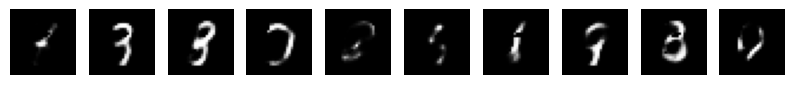

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define the VAE model (Encoder + Decoder)
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.fc1 = nn.Linear(28 * 28, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # Mean of the latent space
        self.fc22 = nn.Linear(400, latent_dim)  # Log-variance of the latent space
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28 * 28)
        
    def encode(self, x):
        h1 = torch.relu(self.fc1(x.view(-1, 28 * 28)))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3)).view(-1, 28 * 28)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function (VAE loss = reconstruction loss + KL divergence)
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x.view(-1, 28 * 28), reduction='sum')
    
    # KL divergence between the learned distribution and the prior (Gaussian)
    # KL(N(mu, sigma^2) || N(0, 1)) = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # where sigma^2 = exp(logvar)
    # The factor 0.5 is needed to match the standard form of the KL divergence.
    # The final KL term for each element is:
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # In our case, we assume the prior is a standard Gaussian (mean=0, std=1).
    # So, the formula simplifies to the following:
    # KL = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    #     = -0.5 * sum(1 + log(exp(logvar)) - mu^2 - exp(logvar))
    
    # Calculate KL divergence
    # log(sigma^2) = logvar
    # mu^2 + sigma^2 = mu^2 + exp(logvar)
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KL

# Define training function
def train(epoch, model, train_loader, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item() / len(data):.6f}')
    
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

# Define test function
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += vae_loss(recon_batch, data, mu, logvar).item()
    
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    
# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Initialize the model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(epoch, model, train_loader, optimizer)
    test(epoch, model, test_loader)

# Sampling from the VAE latent space and visualizing the results
def sample_and_reconstruct(model, num_samples=10):
    with torch.no_grad():
        sample_z = torch.randn(num_samples, model.latent_dim).to(device)
        sample_images = model.decode(sample_z).cpu()
        plt.figure(figsize=(10, 1))
        for i in range(num_samples):
            ax = plt.subplot(1, num_samples, i + 1)
            plt.imshow(sample_images[i].view(28, 28), cmap='gray')
            ax.axis('off')
        plt.show()

# Generate some samples after training
sample_and_reconstruct(model)


In [8]:
%pip install torchvision==0.17.2

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 11.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/198.5 MB ? eta -:--:--
    --------------------------------------- 4.7/198.5 MB 23.8 MB/s eta 0:00:09
   -- ------------------------------------- 10.2/198.5 MB 24.5 MB/s eta 0:00:08
   --- ------------------------------------ 17.3/198.5 MB 28.0 MB/s eta 0:00:07
   ----- ---------------------------------- 25.2/198.5 MB 30.7 MB/s eta 0:00:06
   ------ --------------------------------- 31.5/198.5 MB 30.7 MB/s eta 0:00:06
   ------- -------------------------------- 38.8/198.5 MB 31.6 MB/s eta 0:00:06
   --------- ------------------------------ 45.1/198.5 MB 31.9 MB/s eta 0:00:05
   ---------- ----------------------------- 50.1/198.5 MB 30.1 MB/s eta 0:00:05
   ----------- ---------------------------- 57.7/198.5 MB 30.9 MB/